# <font color = 'royalblue'> <center> Homework: *State Your Assumptions*

### Get the Data

In [135]:
# load packages
from dvc.api import read,get_url
import pandas as pd
import re

# store text file
txt = read('resources/data/shakespeare/shakespeare.txt', 
           repo='https://github.com/TLP-COI/text-data-course')

# view
print(txt[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



### Part 1

Split the text file into a table, such that

- each row is a single line of dialogue
- there are columns for
    - the speaker
    - the line number
    - the line dialogue (the text)

Hint: you will need to use RegEx to do this rapidly. See the in-class "markdown" example!

Question(s):

What assumptions have you made about the text that allowed you to do this?

___

#### <center> Method 1 - writing a RegEx pattern

Assumptions:
- The speaker name always starts with a capital letter.
- If there is more than one word making up a speaker name e.g. First Citizen, all words start with a capital letter.
- Speaker names are always followed by a colon.
- Speaker names are always followed by a line break after the colon.
- The dialogue is always after 'speaker name:\n'

`([A-Z][\w-]*(\s+[A-Z][\w-]*)+)(?=[:$][\r\n])` works in https://regexr.com/, but I haven't been able to use this pattern successfully in this notebook.  

In [136]:
# write regex pattern
patt = re.compile(
    "(?:\A|\n\n)"  # beginning of file or two newlines
    "(^[A-Z][\w ]+):$"  # capital start, colon end
    "\n([\s\S]+?)"  # ANYTHING, but lazy
    "(?=\n\n|\Z)",  # until you hit two newlines or end-of-file
    flags=re.M
)

In [137]:
# store matches
matches = patt.findall(txt)

# store matches in dataframe
df1 = pd.DataFrame.from_records(matches, columns=['speaker', 'dialogue'])

# add line number column starting from 1
df1['line_number'] = df1.index + 1

# view dataframe
df1.head()

,speaker,dialogue,line_number
0,First Citizen,"Before we proceed any further, hear me speak.",1
1,All,"Speak, speak.",2
2,First Citizen,You are all resolved rather to die than to fam...,3
3,All,Resolved. resolved.,4
4,First Citizen,"First, you know Caius Marcius is chief enemy t...",5


#### <center> Method 2 - using the split function from re

The text is structured as follows:

*First Speaker:*\n*Text*\n\n*Next Speaker*

Assumptions:
- the speaker's name is always followed by a colon and a line break
- the text (speaker's dialogue) comes after the colon and line break (after the speaker's name) and ends with double line breaks (/n/n)

**Extract each dialogue spoken and the speaker's name i.e. 'speaker_name:\ndialogue'**

In [138]:
# split on double line breaks
first_split = re.split("\n\n", txt)

# check length of list
len(first_split)

7222

**Separate speaker name and the dialogue**

Assumption:<br>
Speaker name is always followed by a colon. <br>
Since each item in `first_split` contains the speaker's name and the dialogue spoken, splitting on the *first* colon in the string will separate the speaker name and the dialogue.

In [139]:
# create list to store split results
second_split = []

# iterate through each item in the list and split on the first colon
for line in first_split:
    second_split.append(line.split(":", 1))
    
# check length of list
len(second_split)

7222

#### Store speakers and dialogues

In [140]:
# create list to store speakers
speakers = []

# iterate through each item in the list and select the speakers
for line in range(len(second_split)):
    speakers.append(second_split[line][0])

In [141]:
# create list to store dialogues
dialogues = []

# iterate through each item in the list and select the dialogues
for line in range(len(second_split)):
    dialogues.append(second_split[line][1])

In [142]:
# create list to store dialogues
dialogues_1 = []

# remove \n from dialogues
for i in range(len(dialogues)):
    dialogues_1.append(dialogues[i].replace('\n',''))

In [143]:
# create empty dataframe
df = pd.DataFrame()

# store speakers and dialogues in dataframe
df['speaker']  = speakers
df['dialogue'] = dialogues_1

# add line number column starting from 1
df['line_number'] = df.index + 1

# view df
df.head()

,speaker,dialogue,line_number
0,First Citizen,"Before we proceed any further, hear me speak.",1
1,All,"Speak, speak.",2
2,First Citizen,You are all resolved rather to die than to fam...,3
3,All,Resolved. resolved.,4
4,First Citizen,"First, you know Caius Marcius is chief enemy t...",5


### Part 2

You have likely noticed that the lines are not all from the same play! Now, we will add some useful metadata to our table:

- Determine a likely source title for each line
- add the title as a 'play' column in the data table.
- make sure to document your decisions, assumptions, external data sources, etc.

This is fairly open-ended, and you are not being judged completely on accuracy. Instead, think outside the box a bit as to how you might accomplish this, and attempt to justify whatever approximations or assumptions you felt were appropriate.
___

For the source title, I am going to use a Kaggle dataset (https://www.kaggle.com/kingburrito666/shakespeare-plays/version/4) on Shakespeare's plays (including character names and dialogues). 

In [144]:
# read in Shakespeare play data
df_shakespeare = pd.read_csv('Shakespeare_data.csv')

# view
df_shakespeare.head()

,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,1,Henry IV,NaN,NaN,NaN,ACT I
1,2,Henry IV,NaN,NaN,NaN,SCENE I. London. The palace.
2,3,Henry IV,NaN,NaN,NaN,"Enter KING HENRY, LORD JOHN OF LANCASTER, the ..."
3,4,Henry IV,1.0,1.1.1,KING HENRY IV,"So shaken as we are, so wan with care,"
4,5,Henry IV,1.0,1.1.2,KING HENRY IV,"Find we a time for frighted peace to pant,"


In [145]:
# make speaker names uppercase (in order to match) and store in df
speaker_df = pd.DataFrame(df['speaker'].str.upper())
df_shakespeare['Player'] = df_shakespeare['Player'].str.upper()

# rename column to match shakespeare_df column name for speakers
speaker_df.rename(columns = {'speaker':'Player'}, inplace = True)

I will get the list of plays of a specific speaker e.g. all plays with the speaker 'First Citizen'. Then I will select the most common play from this list as the source title/play. The assumption here is that the play in which a specific speaker/character had a lot of dialogues is the most likely source title for the dialogues by the speaker.  

Limitation of this assumption: some dialogues may be from plays where the speaker has a minor part i.e. it may not be the most common play. 

In [146]:
# create empty list to store source titles
plays = []

# store the most common play for each speaker
for i in range(len(speaker_df)):
    plays_list = list(df_shakespeare.loc[df_shakespeare['Player'] == speaker_df.Player[i], 'Play'])
    if len(plays_list) == 0:
        plays.append('none')
    else:
        plays.append(max(set(plays_list), key = plays_list.count))
    
# check length of plays
len(plays)

7222

In [147]:
# add 'play' column 
df['play'] = plays

# view dataframe
df

,speaker,dialogue,line_number,play
0,First Citizen,"Before we proceed any further, hear me speak.",1,Coriolanus
1,All,"Speak, speak.",2,macbeth
2,First Citizen,You are all resolved rather to die than to fam...,3,Coriolanus
3,All,Resolved. resolved.,4,macbeth
4,First Citizen,"First, you know Caius Marcius is chief enemy t...",5,Coriolanus
...,...,...,...,...
7217,ANTONIO,Nor I; my spirits are nimble.They fell togethe...,7218,Merchant of Venice
7218,SEBASTIAN,"What, art thou waking?",7219,Twelfth Night
7219,ANTONIO,Do you not hear me speak?,7220,Merchant of Venice
7220,SEBASTIAN,I do; and surelyIt is a sleepy language and th...,7221,Twelfth Night


In [148]:
# view rows where there was no match 
df[df['play'] == 'none']

,speaker,dialogue,line_number,play
530,"Senators, &C",We'll surety him.,531,none
538,"Senators, &C","Weapons, weapons, weapons!'Tribunes!' 'Patrici...",539,none
2142,Ghost of Prince Edward,,2143,none
2143,Ghost of King Henry VI,,2144,none
2150,Ghosts of young Princes,,2151,none
2152,Ghost of BUCKINGHAM,,2153,none
2750,\nSAMPSON,"Gregory, o' my word, we'll not carry coals.",2751,none
5704,\nMARIANA,"Break off thy song, and haste thee quick away:...",5705,none
6569,ALL SERVING-MEN,"Here, here, sir; here, sir.",6570,none


Assumption: for speakers that were not found in the external dataset and for which there is no play information, the speaker is assumed to be in the same play as the previous speaker. In other words: for rows where there was not an exact match for a speaker, the preceding row will be used to obtain the play/source title. 

Limitation: if the play for the first observation was missing, this would have to be modified. 

In [149]:
# condition: select rows where no play was found
# replace with play in the previous row
s = df["play"].eq("none")
df.loc[s, "play"] = pd.np.nan
df["play"].ffill(inplace=True)

# check - should not return any matches
df[df['play'] == 'none']

C:\Users\marya\AppData\Local\Temp/ipykernel_15388/1585223887.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df.loc[s, "play"] = pd.np.nan


,speaker,dialogue,line_number,play


### Part 3

Pick one or more of the techniques described in this chapter:

- keyword frequency
- entity relationships
- markov language model
- bag-of-words, TF-IDF
- semantic embedding

make a case for a technique to measure how important or interesting a speaker is. The measure does not have to be both important and interesting, and you are welcome to come up with another term that represents "useful content", or tells a story (happiest speaker, worst speaker, etc.)

Whatever you choose, you must
- document how your technique was applied
- describe why you believe the technique is a valid approximation or exploration of how important, interesting, etc., a speaker is.
- list some possible weaknesses of your method, or ways you expect your assumptions could be violated within the text.

This is mostly about learning to transparently document your decisions, and iterate on a method for operationalizing useful analyses on text. Your explanations should be understandable; homeworks will be peer-reviewed by your fellow students

___

I want to explore a few different techniques. I will start off by very basic ones.

### 1

**How many dialogues did each speaker have?**

Assumption: the more dialogues a speaker has, the more important the speaker is.

In [153]:
# convert speaker and play columns to uppercase 
df['speaker'] = df['speaker'].str.upper()
df['play'] = df['play'].str.upper()

In [154]:
# view speakers and dialogue counts
df['speaker'].value_counts().rename_axis('speaker').reset_index(name='total_dialogues')

,speaker,total_dialogues
0,GLOUCESTER,229
1,DUKE VINCENTIO,193
2,ROMEO,163
3,MENENIUS,162
4,PETRUCHIO,158
...,...,...
300,HERBERT,1
301,SURREY,1
302,GHOST OF PRINCE EDWARD,1
303,GHOST OF KING HENRY VI,1


### 2

**What was the proportion of dialogues spoken by each speaker (in each play)?**

Assumption: the relative number of dialogues spoken determines speaker importance e.g. if a speaker has more dialogues compared to other speakers in a play, then that speaker is important. 

In [173]:
# group by play and speaker and create separate columns for each dialogue.
df_prop = df.groupby(['play', 'speaker', 'dialogue']).size().unstack(fill_value=0)

#view
df_prop.head()

dialogue                      \
play           speaker         
A WINTERS TALE ANTIGONUS   1   
               ARCHIDAMUS  0   
               AUTOLYCUS   5   
               CAMILLO     1   
               CLEOMENES   0   

dialogue                   'Alla nostra casa ben venuto, molto honorato signormio Petruchio.' Rise, Grumio, rise: we will compoundthis quarrel.  \
play           speaker                                                                                                                            
A WINTERS TALE ANTIGONUS                                                   0                                                                      
               ARCHIDAMUS                                                  0                                                                      
               AUTOLYCUS                                                   0                                                                      
               CAMILLO                                                     0                                                                      
               CLEOMENES                                                   0                                                                      

dialogue                   'Cucullus non facit monachum:' honest in nothingbut in his clothes; and one that hath spoke mostvillanous speeches of the duke.  \
play           speaker                                                                                                                                       
A WINTERS TALE ANTIGONUS                                                   0                                                                                 
               ARCHIDAMUS                                                  0                                                                                 
               AUTOLYCUS                                                   0                                                                                 
               CAMILLO                                                     0                                                                                 
               CLEOMENES                                                   0                                                                                 

dialogue                   'Fair cousin'? I am greater than a king:For when I was a king, my flatterersWere then but subjects; being now a subject,I have a king here to my flatterer.Being so great, I have no need to beg.  \
play           speaker                                                                                                                                                                                                         
A WINTERS TALE ANTIGONUS                                                   0                                                                                                                                                   
               ARCHIDAMUS                                                  0                                                                                                                                                   
               AUTOLYCUS                                                   0                                                                                                                                                   
               CAMILLO                                                     0                                                                                                                                                   
               CLEOMENES                                                   0                                                                                                                                                   

dialogue                   'Faith, my lord. I spoke it but according 

In [174]:
# store list of columns and only keep columns that are dialogues
column_list = list(df_prop)
column_list = column_list[1:]

In [175]:
# create column to store total number of dialogues by each speaker in each play
df_prop["sum"] = df_prop[column_list].sum(axis=1)

# view
df_prop.head()

dialogue                      \
play           speaker         
A WINTERS TALE ANTIGONUS   1   
               ARCHIDAMUS  0   
               AUTOLYCUS   5   
               CAMILLO     1   
               CLEOMENES   0   

dialogue                   'Alla nostra casa ben venuto, molto honorato signormio Petruchio.' Rise, Grumio, rise: we will compoundthis quarrel.  \
play           speaker                                                                                                                            
A WINTERS TALE ANTIGONUS                                                   0                                                                      
               ARCHIDAMUS                                                  0                                                                      
               AUTOLYCUS                                                   0                                                                      
               CAMILLO                                                     0                                                                      
               CLEOMENES                                                   0                                                                      

dialogue                   'Cucullus non facit monachum:' honest in nothingbut in his clothes; and one that hath spoke mostvillanous speeches of the duke.  \
play           speaker                                                                                                                                       
A WINTERS TALE ANTIGONUS                                                   0                                                                                 
               ARCHIDAMUS                                                  0                                                                                 
               AUTOLYCUS                                                   0                                                                                 
               CAMILLO                                                     0                                                                                 
               CLEOMENES                                                   0                                                                                 

dialogue                   'Fair cousin'? I am greater than a king:For when I was a king, my flatterersWere then but subjects; being now a subject,I have a king here to my flatterer.Being so great, I have no need to beg.  \
play           speaker                                                                                                                                                                                                         
A WINTERS TALE ANTIGONUS                                                   0                                                                                                                                                   
               ARCHIDAMUS                                                  0                                                                                                                                                   
               AUTOLYCUS                                                   0                                                                                                                                                   
               CAMILLO                                                     0                                                                                                                                                   
               CLEOMENES                                                   0                                                                                                                                                   

dialogue                   'Faith, my lord. I spoke it but according 

In [180]:
# reset index
df_prop = df_prop.reset_index()

Let's pick a specific play (A Winter's Tale) and see which speaker was the most important.

C:\Users\marya\AppData\Local\Temp/ipykernel_15388/86333696.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


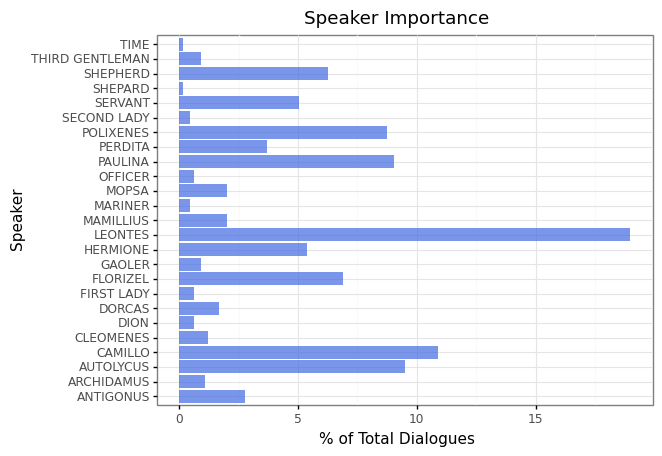

<ggplot: (163109352997)>

In [223]:
winters_tale_df = df_prop[df_prop['play'] == 'A WINTERS TALE']

from plotnine import *

# store percentage
winters_tale_df['percent'] = (winters_tale_df['sum'] / winters_tale_df['sum'].sum()) * 100

# plot 
(ggplot(winters_tale_df,
        aes(x="speaker",
            y="percent")) +
 geom_bar(stat = "identity",
         fill = 'royalblue',
         alpha = 0.7)+
 coord_flip()+
theme_bw() +
 labs(title = 'Speaker Importance',
     y = '% of Total Dialogues',
     x = 'Speaker')
)

In [ ]:
test_df = df.groupby(['play', 'speaker', 'dialogue']).size().unstack(fill_value=0)
test_df

test_df.sum(axis=1)